In [1]:
import json
import pandas as pd
import os

df = pd.DataFrame()
for dirname, _, filenames in os.walk('../data/100/'):
    for filename in filenames:
        data = {}
        with open(os.path.join(dirname, filename),'r') as file:
            d = json.loads(file.read())
        data['date'] = d['Indices']['NDVI']['Serie Processada']['Data']
        data['indices'] = d['Indices']['NDVI']['Serie Processada']['Indice']
        part = pd.DataFrame(data)
        part['date'] = pd.to_datetime(part['date'], format='%Y-%m-%d')
        print(os.path.join(dirname, filename))
        df = pd.concat([df, part])
df.head(10)

../data/100/2014-2015.json
../data/100/2016-2017.json
../data/100/2018-2019.json
../data/100/2015-2016.json
../data/100/2017-2018.json


,date,indices
0,2014-07-04,0.565087
1,2014-07-12,0.577556
2,2014-07-20,0.570085
3,2014-07-28,0.525197
4,2014-08-05,0.479784
5,2014-08-13,0.462151
6,2014-08-21,0.474681
7,2014-08-29,0.500842
8,2014-09-06,0.520316
9,2014-09-14,0.521451


In [2]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.set_index('date')
df = df.groupby(df.index).mean()
df = df.asfreq("W",method='backfill')
df = df.sort_index()
df.head(10)

,indices
date,
2014-07-06,0.577556
2014-07-13,0.570085
2014-07-20,0.570085
2014-07-27,0.525197
2014-08-03,0.479784
2014-08-10,0.462151
2014-08-17,0.474681
2014-08-24,0.500842
2014-08-31,0.520316


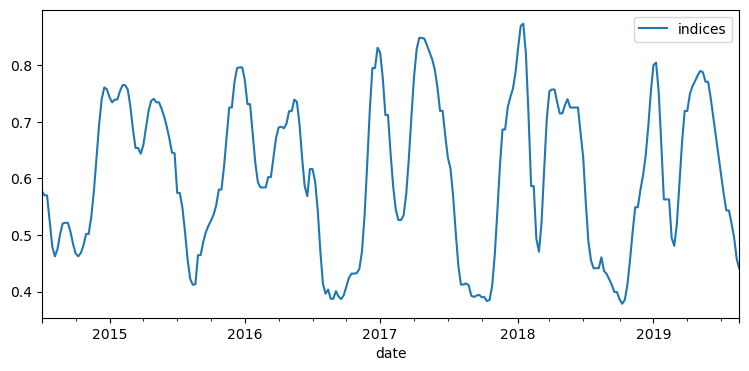

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 4))
df['indices'].plot(ax=ax, label='indices')
ax.legend()

In [4]:
from datetime import datetime

steps=10
X_train = df.loc[:datetime.strptime('2019-02-28', "%Y-%m-%d")]
X_test = df.loc[datetime.strptime('2019-02-28', "%Y-%m-%d"):datetime.strptime('2019-05-30', "%Y-%m-%d")]

In [5]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
auto = auto_arima(
    X_train['indices'],
    seasonal=True,
    stationary=True,
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1092.883, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-273.115, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-914.192, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-563.068, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=458.588, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1065.369, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1094.363, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1023.326, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1096.157, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1094.382, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-1092.689, Time=0.17 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1070.659, Time=0.05 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.437 seconds


In [6]:
sarima = SARIMAX(X_train['indices'],order=auto.order,seasonal_order=(1,2,1,8),freq='W',enforce_stationarity=True)
model = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51463D+00    |proj g|=  5.74323D+00


/home/pedro/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



At iterate    5    f= -1.55218D+00    |proj g|=  6.27580D-01

At iterate   10    f= -1.65999D+00    |proj g|=  1.16882D+01

At iterate   15    f= -1.74317D+00    |proj g|=  1.62732D-01

At iterate   20    f= -1.78553D+00    |proj g|=  6.07047D-01

At iterate   25    f= -1.78665D+00    |proj g|=  1.05463D-01

At iterate   30    f= -1.78671D+00    |proj g|=  2.17998D-01

At iterate   35    f= -1.78756D+00    |proj g|=  5.36101D-01

At iterate   40    f= -1.78961D+00    |proj g|=  5.98462D-01

At iterate   45    f= -1.79036D+00    |proj g|=  5.74274D-02

At iterate   50    f= -1.79049D+00    |proj g|=  9.63367D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/pedro/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
forecast = model.get_forecast(steps=len(X_test))
print(type(forecast))
forecast = pd.DataFrame(forecast.predicted_mean)
forecast.head(10)

<class 'statsmodels.tsa.statespace.mlemodel.PredictionResultsWrapper'>


,predicted_mean
2019-03-03,0.469347
2019-03-10,0.445592
2019-03-17,0.389663
2019-03-24,0.337127
2019-03-31,0.298579
2019-04-07,0.353173
2019-04-14,0.419977
2019-04-21,0.426335
2019-04-28,0.459114
2019-05-05,0.476434


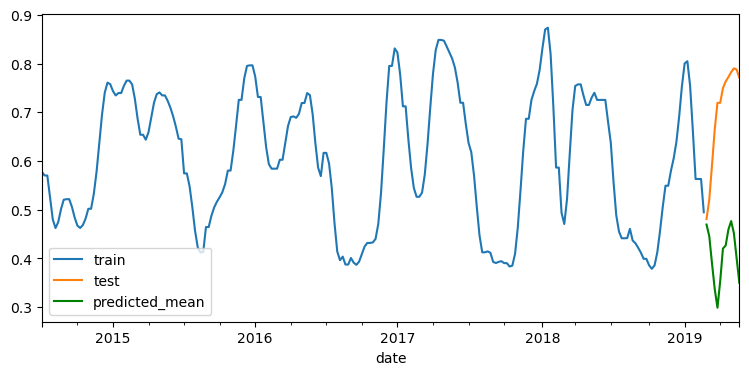

In [8]:
fig, ax=plt.subplots(figsize=(9, 4))
X_train['indices'].plot(ax=ax, label='train')
X_test['indices'].plot(ax=ax, label='test')
forecast.plot(ax=ax, label='predictions', color='green')
ax.legend()